In [1]:
pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import import_ipynb

Enter dimension of the maze (dim): 2000
Enter obstacle probability (p): 0.3
Enter obstacle removal probability (rho): 0.5
Enter heuristic (Manhattan (m) / Euclidean (e)): m


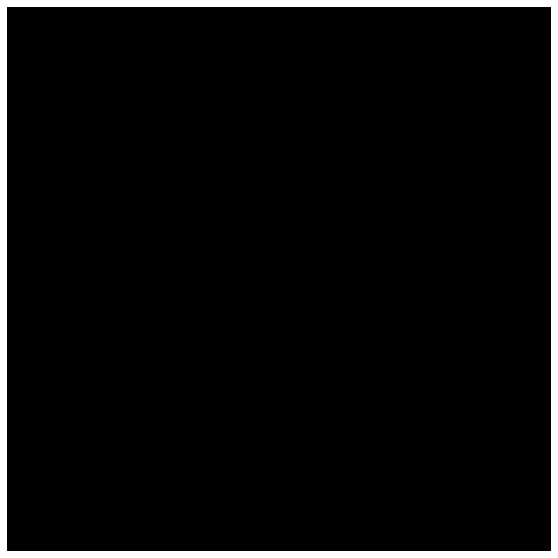

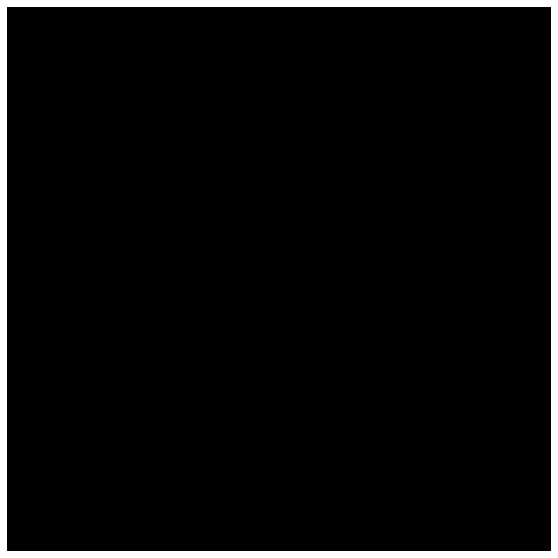

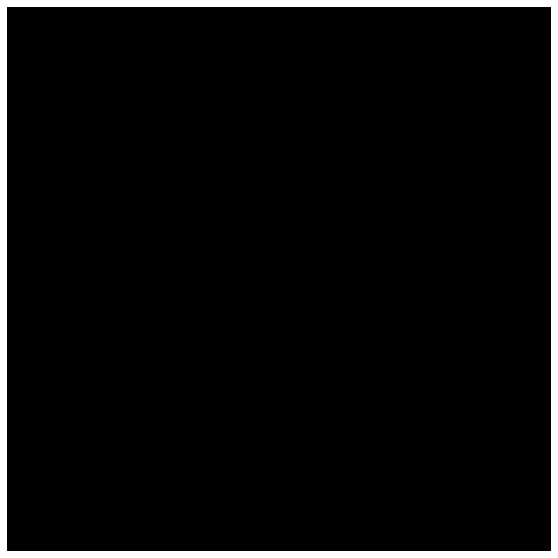

This maze is unsolvable!


In [4]:
import numpy as np
import random
from queue import PriorityQueue
import matplotlib.pylab as plt
import display

class Maze(object):
    def __init__(self, x = None, y = None, open = None):
        self.closed_set = set()         
        self.fringe = PriorityQueue()   # Use a priority queue for the fringe
        self.max_fringe_size = 0            
        self.nodes = []                 # List to store all the maze nodes
        self.dim = 0                    # Dimension of the maze
        self.x = x                      # x co-ordinate of node
        self.y = y                      # y co-ordinate of node
        self.parent = None
        self.h = 0                      # Heuristic value
        self.f = 0                      # F-value
        self.cost = {}                  # Dict to store path costs
        self.shortest_path_length = 0
        self.nodes_expanded = 0
        self.open = open                # Bool: True if node is open, False if node is blocked
        self.finish = False             # Bool: True when goal is found

    def create_maze(self, dim, p):
        """
        Create the maze: 
        Blocked nodes are represented by 0 (with probability 'p'), 
        Open nodes by 1 (with probability '1-p'), and
        Traversed nodes by 2
        :param dim: dimension of the maze to be created
        :param p: probability of obstacles/obstacle density
        """
        self.dim = dim
        maze = np.random.choice([0, 1], (dim,dim), p=[p, 1-p]) # [Blocked/0, Open/1]
        maze[0][0] = 2          # Denote start by 2
        maze[dim-1][dim-1] = 2  # Denote goal by 2
        return maze
        
    def get_node(self, x, y):
        return self.nodes[x * self.dim + y]

    # Find immediate neighbors of any given node
    def find_neighbors(self, node):
        nodes = []
        # Right
        if node.x < self.dim-1:
            nodes.append(self.get_node(node.x + 1, node.y))
        # Left
        if node.x > 0:
            nodes.append(self.get_node(node.x - 1, node.y))
        # Up
        if node.y < self.dim-1:
            nodes.append(self.get_node(node.x, node.y + 1))
        # Down
        if node.y > 0:
            nodes.append(self.get_node(node.x, node.y - 1))
        return nodes

    def init_maze(self, dim, p):        
        """
        Initialize the maze with given dim and p
        :param dim: dimension of the maze to be created
        :param p: probability of obstacles/obstacle density
        """
        self.maze = self.create_maze(dim, p)
        for x in range(self.dim):
            for y in range(self.dim):
                # node is blocked
                if self.maze[x][y] == 0:
                    open = False
                # node is open
                else:
                    open = True
                self.nodes.append(Maze(x, y, open)) # Append all nodes to 'nodes' list
        self.start = self.get_node(0, 0)
        self.goal = self.get_node(self.dim - 1, self.dim - 1)
        
    def get_euclidean_dist(self, node):
        return np.sqrt((node.x - self.goal.x)**2 + (node.y - self.goal.y)**2)

    def get_manhattan_dist(self, node):
        return np.abs(node.x - self.goal.x) + np.abs(node.y - self.goal.y)

    def calc_heuristic(self, node, heuristic):
        if heuristic == "m":
            return self.get_manhattan_dist(node)
        return self.get_euclidean_dist(node)
          
    # Function to display the shortest traversed path by agent from start to goal
    def display_path(self):
        node = self.goal # Set goal node
        self.shortest_path_length = 0
        print('\nPath traversed:\n')
        print('=== GOAL ===')
        
        # Find length of shortest path
        # Keep on expanding nodes until shortest path to goal is found 
        while node.parent is not self.start:
            node = node.parent  
            self.shortest_path_length += 1
            self.maze[node.x][node.y] = 2
            print('(', node.x, ',', node.y, ')')            
            
        # Display the maze with highlighted path
        display.print_maze(self.maze)
        self.shortest_path_length += 2
        print('=== START ===\n')
        print('\nShortest path length: ',self.shortest_path_length)
        print('Nodes expanded: ',self.nodes_expanded)
        print('Maximum fringe size: ',self.max_fringe_size)
                   
    # Thinning Astar
    def run_thinning_astar(self, dim, p, heuristic, rho):  
        self.init_maze(dim, p)
        self.fringe.put((self.start.f, 0, self.start)) # Initiate fringe with f-val, nodes expanded, start node
        self.cost[self.start] = 0

        # Display maze before thinning
        display.print_maze(self.maze)
        
        # Thinning logic
        no_of_blocked_nodes = (self.maze==0).sum()     # Number of blocked nodes
        nodes_to_remove = round(no_of_blocked_nodes * rho)   # Number of blocked nodes to remove

        while nodes_to_remove >= 1:
            for x in range(dim):
                for y in range(dim):
                    if self.maze[x][y] == 0:  
                        rand_prob = random.uniform(0,1)
                        if rand_prob < rho:
                            self.maze[x][y] = 1
                            nodes_to_remove -= 1

        # Display maze after thinning
        display.print_maze(self.maze)
        
        # While fringe is not empty, add visited nodes to closed set
        while not self.fringe.empty():
            f_val, x, node = self.fringe.get()
            self.closed_set.add(node)       
            # Goal found
            if node is self.goal:         
                self.finish = True
                self.nodes_expanded += 1
                return self.display_path()
        
            neighbors = self.find_neighbors(node)
            for neighbor in neighbors:
                # Neighbor is open and unvisited
                if neighbor.open and neighbor not in self.closed_set:
                    new_cost = self.cost[node]   
                   
                    # Update cost if new cost is lower
                    if neighbor not in self.cost or self.cost[neighbor] > new_cost:
                        self.cost[neighbor] = new_cost        
                        neighbor.parent = node         
                        f_val = new_cost + self.calc_heuristic(neighbor, heuristic) 
                        self.fringe.put((f_val, self.nodes_expanded, neighbor)) 
                        self.max_fringe_size = len(self.fringe.queue)
                        self.nodes_expanded += 1
             
        # If there's no path from start to goal
        if(self.finish == False):
            display.print_maze(self.maze)
            print('This maze is unsolvable!')
            
obj = Maze()
dim = int(input('Enter dimension of the maze (dim): '))
p = float(input('Enter obstacle probability (p): '))
rho = float(input('Enter obstacle removal probability (rho): '))
heuristic = input('Enter heuristic (Manhattan (m) / Euclidean (e)): ')

obj.run_thinning_astar(dim, p, heuristic, rho)